In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, average_precision_score, recall_score, \
    classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydot
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 365)
pd.set_option('display.width', 700)

Load the dataset both train and test

In [10]:
train_data = pd.read_csv("data/train.csv", sep=';', index_col='ID')
test_data = pd.read_csv("data/test.csv", sep=';', index_col='ID')

Functions that are used during the project 

In [11]:
def treat_categoricals(df, columns_list=[]):
    """ Treat the categorical variable as numerical"""
    for col_item in columns_list:
        df[col_item] = df[col_item].astype('category')
    df[columns_list] = df[columns_list].apply(lambda col: col.cat.codes)
    return df


def data_preparation(df, lab=False, drop_list=[]):
    """ integrated the data preparation include: dummy variable, missing value, etc."""

    def create_dummy_variables(df):
        # country and website separator
        new_col = np.array(list(df.apply(lambda x: re.findall('..', x['WEBSITE']), axis=1)))
        df['WEBSITE'] = np.array(list(new_col))[:, 0]
        df['COUNTRY'] = np.array(list(new_col))[:, 1]
        # trip duration (day)
        df['duration'] = pd.to_datetime(df['ARRIVAL'], format="%d/%B") - pd.to_datetime(df['DEPARTURE'],
                                                                  format="%d/%B")
        df['duration'] = (df['duration'] / np.timedelta64(1, 'D')).astype(int)
        df.loc[df.duration < 0, 'duration'] = df['duration'] + 365
        df['DEPARTURE_Month'] = pd.to_datetime(df['DEPARTURE'], format="%d/%B").dt.month
        df['ARRIVAL_Month'] = pd.to_datetime(df['ARRIVAL'], format="%d/%B").dt.month
        if lab:
            train_data['color'] = np.where(train_data[['EXTRA_BAGGAGE']], 'green', 'red')
            train_data['label'] = np.where(train_data[['EXTRA_BAGGAGE']], 1, 0)
        return df
    df = create_dummy_variables(df)
    # change the Distance to float Km
    df['DISTANCE'].replace(regex=True, inplace=True, to_replace=r',', value=r'')
    df['DISTANCE'] = df['DISTANCE'].astype('float64')
    df['DISTANCE'] = df['DISTANCE'] / 1000
    df.drop(drop_list, axis=1, inplace=True)
    return df


def EXTRA_BAGGAGE_histogram(data, factor=None, lab='label'):
    """ Plot the histogram of a factor tha is colored by the label class."""
    EXTRA_BAGGAGE = data[factor].iloc[(train_data[lab] == 1).values]
    NO_EXTRA_BAGGAGE = data[factor].iloc[(train_data[lab] == 0).values]

    x_w = np.empty(EXTRA_BAGGAGE.shape)
    x_w.fill(1 / EXTRA_BAGGAGE.shape[0])
    y_w = np.empty(NO_EXTRA_BAGGAGE.shape)
    y_w.fill(1 / NO_EXTRA_BAGGAGE.shape[0])

    plt.hist([EXTRA_BAGGAGE, NO_EXTRA_BAGGAGE], bins=14, weights=[x_w, y_w],
             label=['EXTRA_BAGGAGE', 'NO_EXTRA_BAGGAGE'])
    plt.legend(loc='upper right')
    plt.xlabel(factor)
    plt.ylabel('Empirical PDF')
    plt.title('Trip:{}'.format(factor))
    plt.legend()
    plt.show()


def treat_outliears(data, action='NaN'):
    """ The PCA and Mahalanobis distance are used to detect the outliers that are treated by "action """
    pca = PCA()
    # Run PCA on scaled data and obtain the scores array
    T = pca.fit_transform(StandardScaler().fit_transform(data.select_dtypes(include='int64')))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

    # Score plot of the first 2 PC
    with plt.style.context(('ggplot')):
        plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet', c=data['color'])
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('Score Plot')
    plt.show()
    print("The first 8 component are describing the 90% of variance among the data.")

    # Mahalanobis distance for evaluating the overall distance of the outliers.
    # fit a Minimum Covariance Determinant (MCD) robust estimator to data
    robust_cov = MinCovDet().fit(T[:, :7])

    # Get the Mahalanobis distance
    m = robust_cov.mahalanobis(T[:, :7])
    plt.hist(m, density=True, bins=50)
    plt.ylabel('Probability')
    plt.xlabel('Mahalanobis distance')
    plt.title('Mahalanobis distance histogram')
    plt.xlim(-1, 700)
    plt.show()
    return 0


def validation_report(predictions, y_test):
    """ Generate and print the model validation report"""
    # Calculate the absolute errors
    errors = abs(predictions - y_test)

    # result_accuracy.at[name, fs_item] = accuracy_score(predictions, y_test)
    print('-' * 50)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    print('Accuracy:', accuracy_score(predictions, y_test))
    print('Normalized Accuracy:', accuracy_score(predictions, y_test, normalize=False))
    print('Mean squared error:', mean_squared_error(predictions, y_test))
    print('average_precision:', average_precision_score(predictions, y_test))
    print('recall_score:', recall_score(predictions, y_test))
    print(classification_report(predictions, y_test))
    print('-' * 50)


def plot_feature_importances(df, n=10, threshold=None):
    """Plots n most important features.

    :param
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".

        n (int): Number of most important features to plot. Default is 15.

        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance.

    :return
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1)
                        and a cumulative importance column
    """
    plt.style.use('fivethirtyeight')

    # Sort features with most important at the head
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)

    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12

    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y='importance_normalized',
                            x='feature', color='darkgreen',
                            edgecolor='k', figsize=(12, 8),
                            legend=False, linewidth=2)

    plt.xlabel('Normalized Importance', size=18);
    plt.ylabel('');
    plt.title(f'{n} Most Important Features', size=18)
    plt.gca().invert_yaxis()

    if threshold:
        # Cumulative importance plot
        plt.figure(figsize=(8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size=16);
        plt.ylabel('Cumulative Importance', size=16);
        plt.title('Cumulative Feature Importance', size=18);

        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))

        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin=0, ymax=1.05, linestyles='--', colors='red')
        plt.show();

        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1,
                                                                                  100 * threshold))
    return df

# Data Preparation
The same data cleaning producer is applied for both train and test data.

### Create dummy variables and eliminate some variables
* The 'TIMESTAMP', 'DEPARTURE', 'ARRIVAL', 'SMS', 'DEVICE' are dropped.
* The 'ARRIVAL_Month' and 'DEPARTURE_Month' are generated instead of the date.
* The 'duration' of trip is calculated.
* The the 'WEBSITE' and "COUNTRY'

In [12]:
drop_list = ['TIMESTAMP', 'DEPARTURE', 'ARRIVAL', 'SMS', 'DEVICE']
train_data = data_preparation(train_data, lab=True, drop_list=drop_list)
test_data = data_preparation(test_data, drop_list=drop_list)

### Treating the Missing Values 
There were some NaN values just in the 'DEVICE' column (train 133/test 52), but the factor was deleted.
So, it is not needed to do more.

### Outlier handling

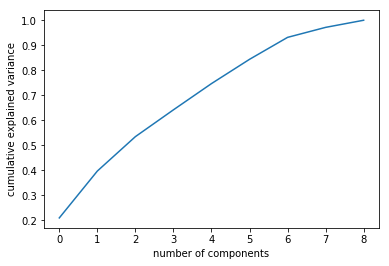

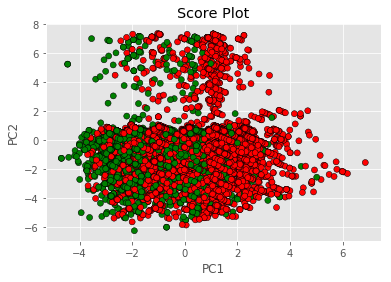

The first 8 component are describing the 90% of variance among the data.


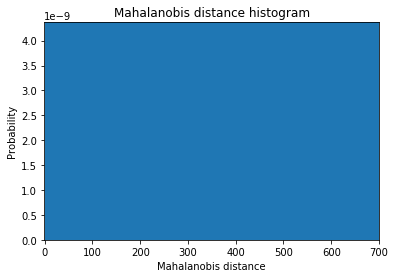

0

In [13]:
treat_outliears(train_data)

As we can see the Mahalanobis distance has uniform distribution then there is not any outliers obviously.

# Feature Relation investigation and 

We start seeing basic characteristics of EXTRA_BAGGAGE=True:

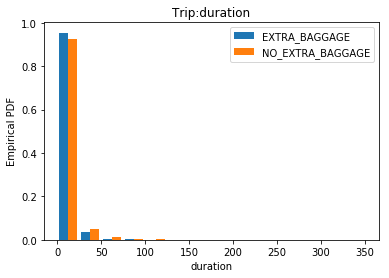

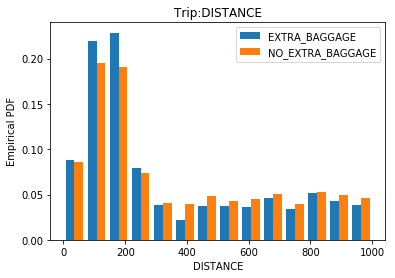

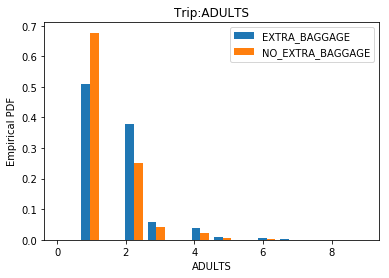

In [14]:
list_for_histogram = ['duration', 'DISTANCE', 'ADULTS']
for variable in list_for_histogram:
    EXTRA_BAGGAGE_histogram(train_data, variable)

Significantly, if the number of passenger, trip duration and distance is big, the chance of buying EXTRA_BAGGAGE is higher

Take look at the feature correlation

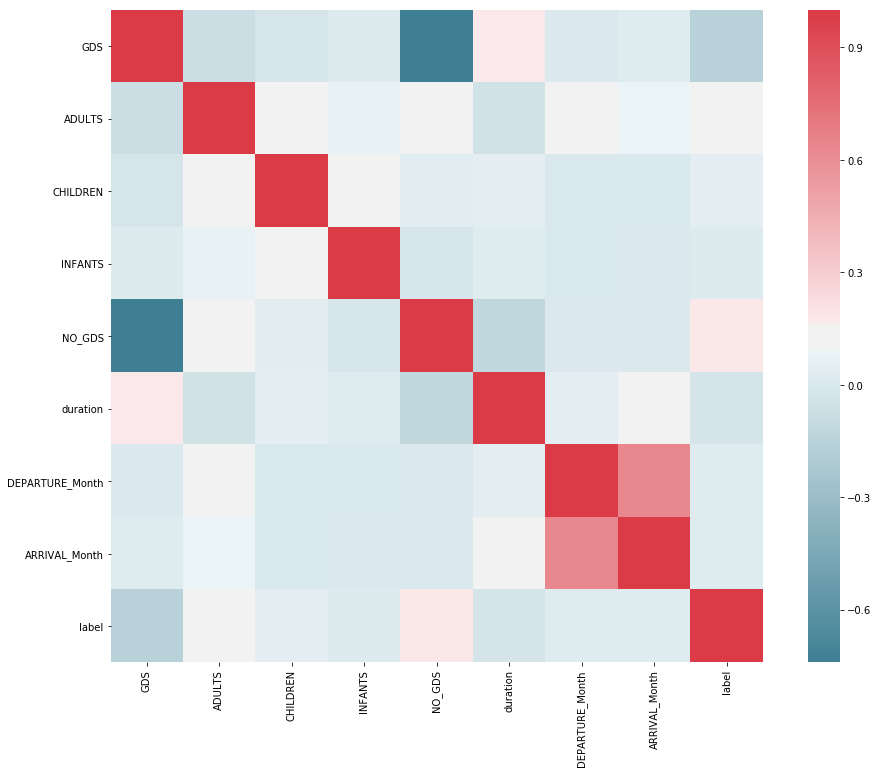

In [15]:
fig = plt.figure(figsize=(16, 12))
corr = train_data.select_dtypes(include='int64').corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()
train_data.drop(['NO_GDS'], axis=1, inplace=True)
test_data.drop(['NO_GDS'], axis=1, inplace=True)

The GDS and no_GDS significantly correlate so No_GDS is eliminated from data set.

#  Unbalanced labels treating

Percentage of EXTRA_BAGGAGE: 19.6%


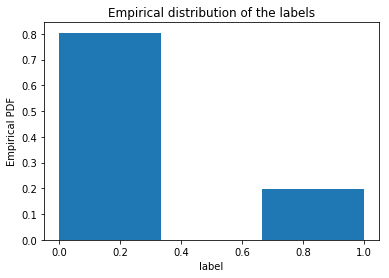

In [16]:
print('Percentage of EXTRA_BAGGAGE: {0}%'.format(round(100 * train_data['label'].sum() / len(train_data['label']), 2)))
plt.hist(train_data['label'], bins=3, weights=np.ones(len(train_data['label'])) / len(train_data['label']))
plt.xlabel('label')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the labels')
plt.show()

We see that the labels are unbalanced. 0 (No EXTRA_BAGGAGE) is highly represented whereas 1 (EXTRA_BAGGAGE) represents
only 20% of the data.
Beside that, The goal of this task is to predict which new customers are going to purchase additional
baggage for their trips using historical from previous customer.
As result of the unbalance label, The preliminary classifier shows:
* excellent True negative precision (99%)
* atrocious True positive precision (09%) that is dramatically less than random selection.

In order to mitigate this shortcoming, the label unbalance issue is treated by resample in next step.

In [17]:
# Separate majority and minority classes
df_majority = train_data[train_data.label == 0]
df_minority = train_data[train_data.label == 1]

# Up sample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # sample with replacement
                                 n_samples=df_majority.shape[0],  # to match majority class
                                 random_state=4)  # reproducible results

# Combine majority class with up sampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
train_data = df_upsampled.copy()
print('new class counts:')
print(train_data.groupby(['label']).size())

new class counts:
label
0    40201
1    40201
dtype: int64


# Model the classifier

### Data frame preparation for modeling

In [18]:
df = train_data.copy()
labs = df['label']
df = df.drop(['label', 'color', 'EXTRA_BAGGAGE'], axis=1)
df = treat_categoricals(df, ['WEBSITE', 'TRAIN', 'HAUL_TYPE', 'TRIP_TYPE', 'PRODUCT', 'COUNTRY'])
df_ordinal = df.copy(deep=True)
cols = df.columns
df = pd.DataFrame(data=df, columns=cols)
feature_list = list(df.columns)
df = np.array(df)
# Labels are the values we want to predict
labels = np.array(labs)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.25,
                                                    random_state=42)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Validating Features Shape:', X_test.shape)
print('Validating Labels Shape:', y_test.shape)

Training Features Shape: (60301, 14)
Training Labels Shape: (60301,)
Validating Features Shape: (20101, 14)
Validating Labels Shape: (20101,)


## Modeling random forest classifier

### Preliminary model

In [19]:
clf = RandomForestClassifier(max_depth=10, n_estimators=30, max_features=5)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
predictions = clf.predict(X_test)
predictions = np.around(np.array(predictions))
validation_report(predictions, y_test)
base_accuracy_RF = accuracy_score(predictions, y_test)

# %% md
## Tuning the hyper parameters of model Grid Search

--------------------------------------------------
Mean Absolute Error: 0.29 degrees.
Accuracy: 0.7137455847967763
Normalized Accuracy: 14347
Mean squared error: 0.2862544152032237
average_precision: 0.6876875120766175
recall_score: 0.7000369412633912
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      9273
           1       0.75      0.70      0.72     10828

   micro avg       0.71      0.71      0.71     20101
   macro avg       0.71      0.71      0.71     20101
weighted avg       0.72      0.71      0.71     20101

--------------------------------------------------


In [20]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

### random grid parameters dictionary

In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 13, 15, 17]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 5, 6, 7, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': ['gini', 'entropy'],
               'warm_start': [True, False],
               }

### <span style="color:red">Warning: The tuning process need some minutes, you can scape it, the final model is available in flowing.</span>

Use the random grid to search for best hyper parameters

In [ ]:
# create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 10 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=20, cv=10, verbose=2,
                               random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

# The final classifier model
The tuned/final model with the best hyper parameters

In [22]:
clf = RandomForestClassifier(max_depth=40,
                             n_estimators=1400,
                             max_features='sqrt',
                             min_samples_split=10,
                             bootstrap=False,
                             min_samples_leaf=1,
                             criterion='entropy',
                             warm_start=True)

### Validate the final model

In [23]:
clf.fit(X_train_rf, y_train)
score = clf.score(X_test_rf, y_test)
predictions = clf.predict(X_test_rf)
predictions = np.around(np.array(predictions))
validation_report(predictions, y_test)
final_accuracy_RF = accuracy_score(predictions, y_test)
print('Random Forest model: Improvement of {:0.2f}%.'.format(
    100 * (final_accuracy_RF - base_accuracy_RF) / base_accuracy_RF))


--------------------------------------------------
Mean Absolute Error: 0.12 degrees.
Accuracy: 0.8814486841450674
Normalized Accuracy: 17718
Mean squared error: 0.11855131585493259
average_precision: 0.8701996146271791
recall_score: 0.8501681971088281
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      9102
           1       0.93      0.85      0.89     10999

   micro avg       0.88      0.88      0.88     20101
   macro avg       0.88      0.88      0.88     20101
weighted avg       0.89      0.88      0.88     20101

--------------------------------------------------
Random Forest model: Improvement of 23.50%.


# Conclusion and Report

### Feature importance

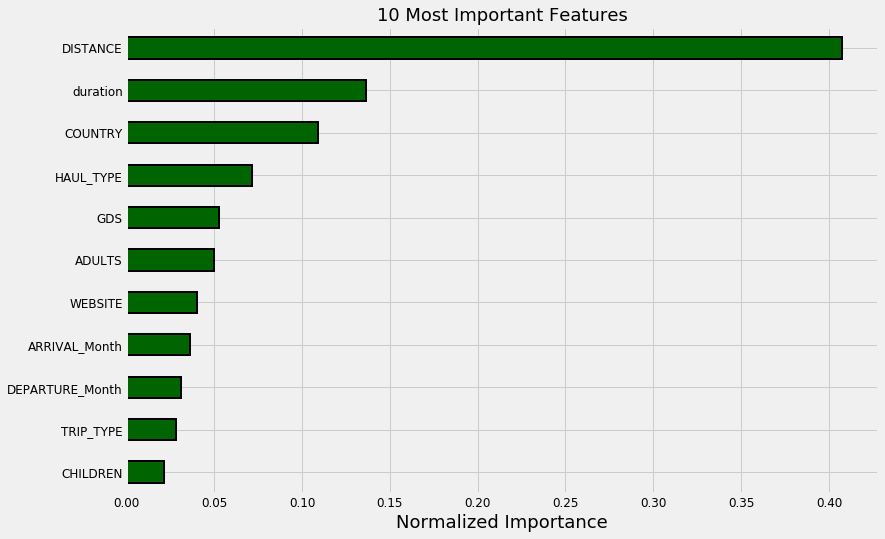

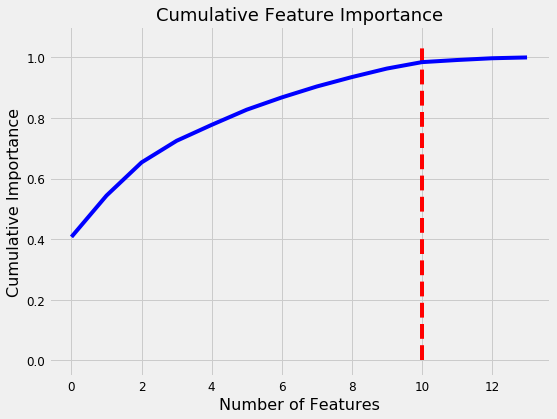

10 features required for 95% of cumulative importance.


In [25]:
feature_importances = pd.DataFrame({'feature': cols, 'importance': clf.feature_importances_})
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)


### Visualize Single Decision Tree

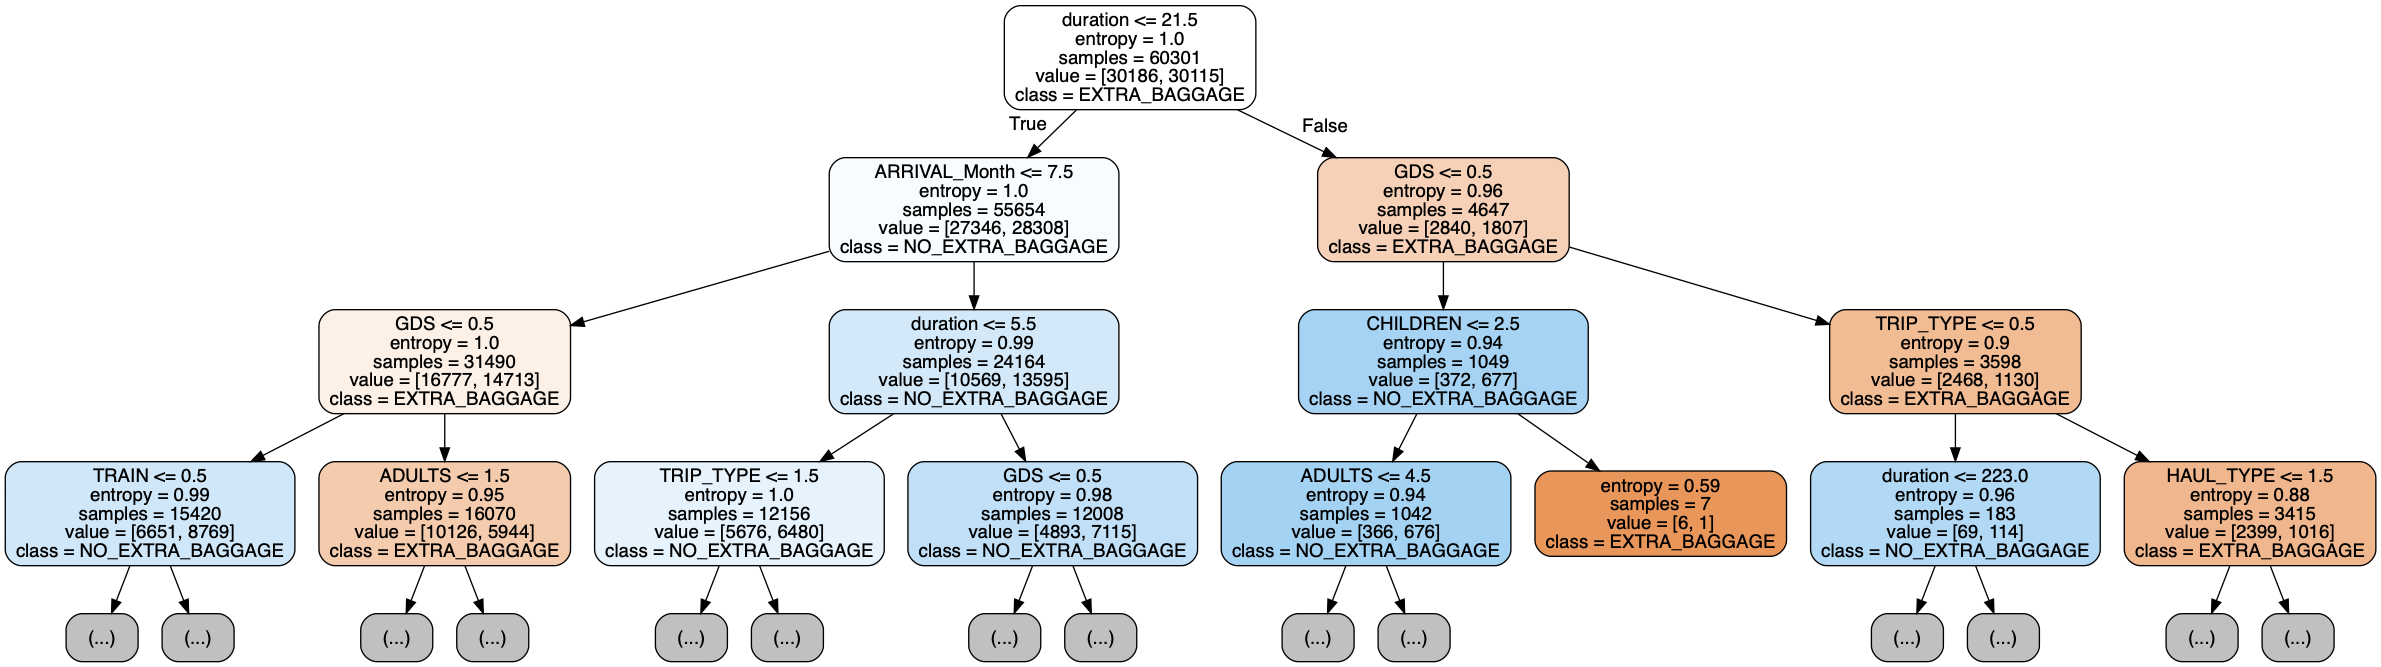

In [26]:
estimator = clf.estimators_[-1]
export_graphviz(estimator, out_file='tree.dot', feature_names=cols,
                class_names=['EXTRA_BAGGAGE', 'NO_EXTRA_BAGGAGE'],
                rounded=True, proportion=False, precision=2, filled=True, max_depth=3)
# convert the .dot file to the .png
try:
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    graph.write_png('tree.png')
except:
    pass
Image(filename='tree.png')

# Predict the test labels and write the output csv

In [27]:
df = test_data.copy()
df = treat_categoricals(df, ['WEBSITE', 'TRAIN', 'HAUL_TYPE', 'TRIP_TYPE', 'PRODUCT', 'COUNTRY'])
df = np.array(df)
test_data['label'] = np.around(np.array(clf.predict(df)))
test_data['ID'] = test_data.index+1
test_data['EXTRA_BAGGAGE'] = np.where(test_data[['label']], 'TRUE', 'FALSE')
export_csv = test_data[['ID', 'EXTRA_BAGGAGE']].to_csv(r'test_with_label.csv', index=None, header=True)